## Import Library

In [1]:
# import library
import pandas as pd
import numpy as np
# from pandas_datareader import data as pdr
import yfinance as yf 
# yf.pdr_override() 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('fivethirtyeight')

In [2]:
import pymc as pm
import arviz as az

In [3]:
print(np.__version__)
print(pm.__version__)
print(az.__version__)

1.23.5
5.7.2
0.19.0


## Prepare Dataset

In [4]:
# set Kyowa Kirin Co., Ltd. and Nikkei 225
stock_e ='4151.T'
stock_m = '^N225'

# set period
start = pd.to_datetime('2021-03-01') 
end = pd.to_datetime('2024-02-29')

# select columns
col_li = ["Adj Close"]

In [5]:
# get data
data_e = yf.download(stock_e, start=start, end=end)
data_m = yf.download(stock_m, start=start, end=end)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [6]:
# column extraction
adjClose_e = data_e[col_li].rename(columns={"Adj Close":"adj_close_a"})
adjClose_m = data_m[col_li].rename(columns={"Adj Close":"adj_close_m"})

In [7]:
# extracting only the end of the month
M_adjClose_e = adjClose_e.resample("ME").last()
M_adjClose_m = adjClose_m.resample("ME").last()

# merge
M_adjClose_merge_df = pd.merge(M_adjClose_e, M_adjClose_m, on="Date", how="inner")

# caluculate log return
M_adjClose_merge_df[['a_log_ret','m_log_ret']] = (
    np.log(M_adjClose_merge_df[['adj_close_a','adj_close_m']]
           /M_adjClose_merge_df[['adj_close_a','adj_close_m']]
           .shift(1))
)
M_adjClose_merge_df.dropna(inplace=True)

In [8]:
# head and shape
print(f"===== dataframe of {stock_e} (equity)=====")
print(M_adjClose_e.shape)
display(M_adjClose_e.head())

print(f"===== dataframe of {stock_m} (market)=====")
print(M_adjClose_m.shape)
display(M_adjClose_m.head())

print(f"===== dataframe of merge_df=====")
print(M_adjClose_merge_df.shape)
display(M_adjClose_merge_df.head())

===== dataframe of 4151.T (equity)=====
(36, 1)


,adj_close_a
Date,
2021-03-31,3109.640137
2021-04-30,3119.034912
2021-05-31,3109.640137
2021-06-30,3723.295410
2021-07-31,3359.470703


===== dataframe of ^N225 (market)=====
(36, 1)


,adj_close_m
Date,
2021-03-31,29178.800781
2021-04-30,28812.630859
2021-05-31,28860.080078
2021-06-30,28791.529297
2021-07-31,27283.589844


===== dataframe of merge_df=====
(35, 4)


,adj_close_a,adj_close_m,a_log_ret,m_log_ret
Date,,,,
2021-04-30,3119.034912,28812.630859,0.003017,-0.012629
2021-05-31,3109.640137,28860.080078,-0.003017,0.001645
2021-06-30,3723.295410,28791.529297,0.180102,-0.002378
2021-07-31,3359.470703,27283.589844,-0.102826,-0.053796
2021-08-31,3397.270996,28089.539062,0.011189,0.029112


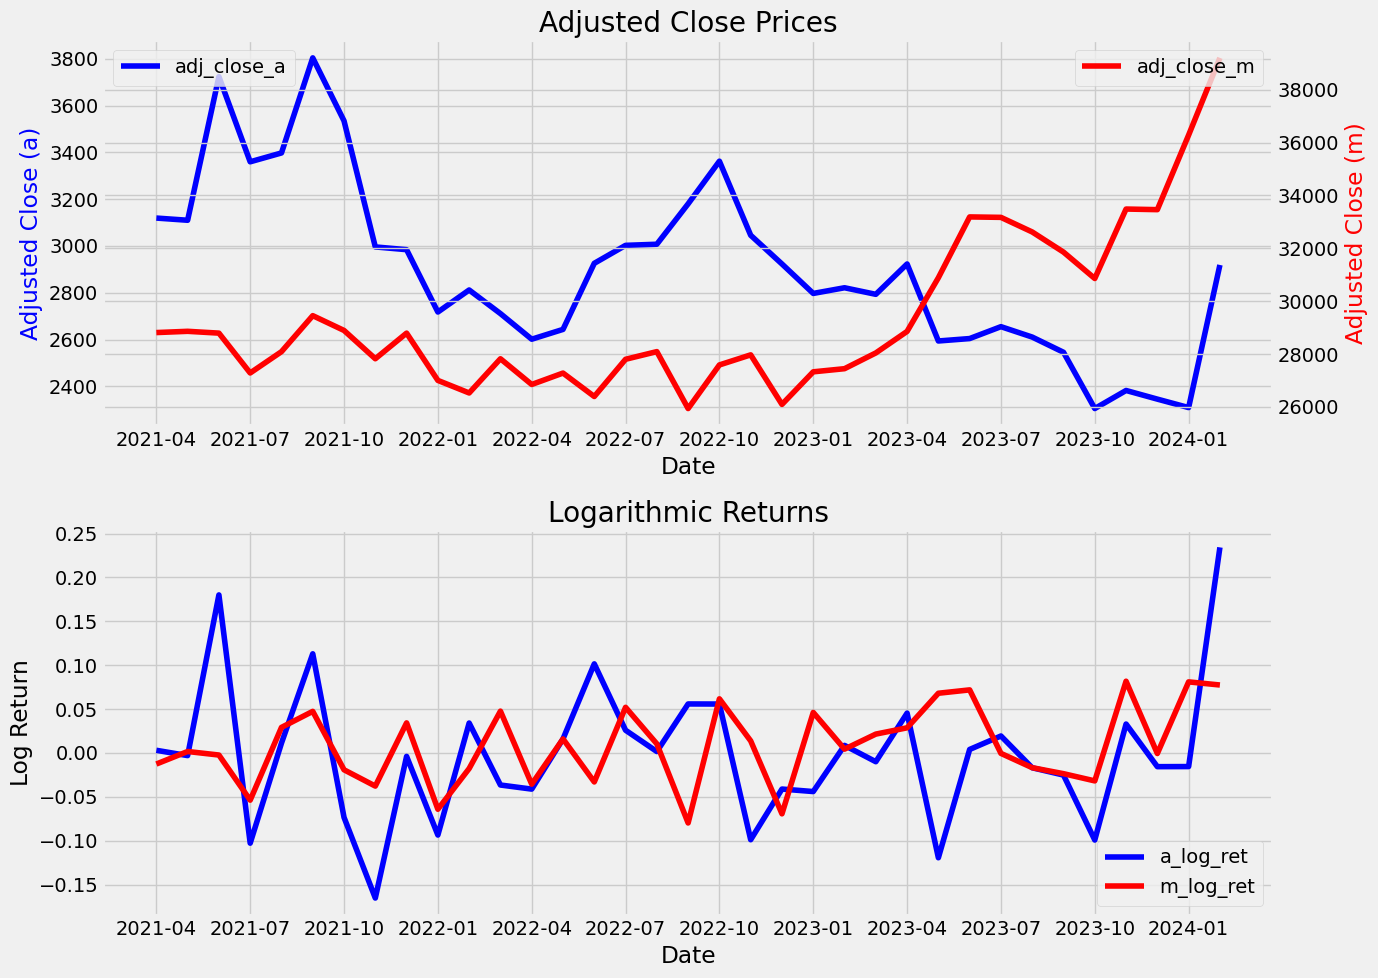

In [9]:
# Reset the index
merge_df_reset = M_adjClose_merge_df.reset_index()
merge_df_reset["YearMonth"] = merge_df_reset["Date"].dt.strftime('%Y-%m')

plt.figure(figsize=(14, 10))

# first plot
plt.subplot(2, 1, 1)
ax1 = plt.gca()  # primary axis
ax2 = ax1.twinx()  # Secondary axis

ax1.plot(merge_df_reset["YearMonth"], merge_df_reset['adj_close_a'], label='adj_close_a', color='blue')
ax2.plot(merge_df_reset['YearMonth'], merge_df_reset['adj_close_m'], label='adj_close_m', color='red')

ax1.set_title('Adjusted Close Prices')
ax1.set_xlabel('Date')
ax1.set_ylabel('Adjusted Close (a)', color='blue')
ax2.set_ylabel('Adjusted Close (m)', color='red')

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

ax1.grid(True)

# Custom tick placement - 3 months apart
tick_indices = np.arange(0, len(merge_df_reset), 3)  # Get indices for every 3 months
ax1.set_xticks(tick_indices)
ax1.set_xticklabels(merge_df_reset['YearMonth'].iloc[tick_indices])

# second plot
plt.subplot(2, 1, 2)
plt.plot(merge_df_reset['YearMonth'], merge_df_reset['a_log_ret'], label='a_log_ret', color='blue')
plt.plot(merge_df_reset['YearMonth'], merge_df_reset['m_log_ret'], label='m_log_ret', color='red')
plt.title('Logarithmic Returns')
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.legend()
plt.grid(True)

# Custom tick placement - 3 months apart
plt.xticks(tick_indices, merge_df_reset['YearMonth'].iloc[tick_indices])

plt.tight_layout()
plt.show()

## Simple Liner Regresiion

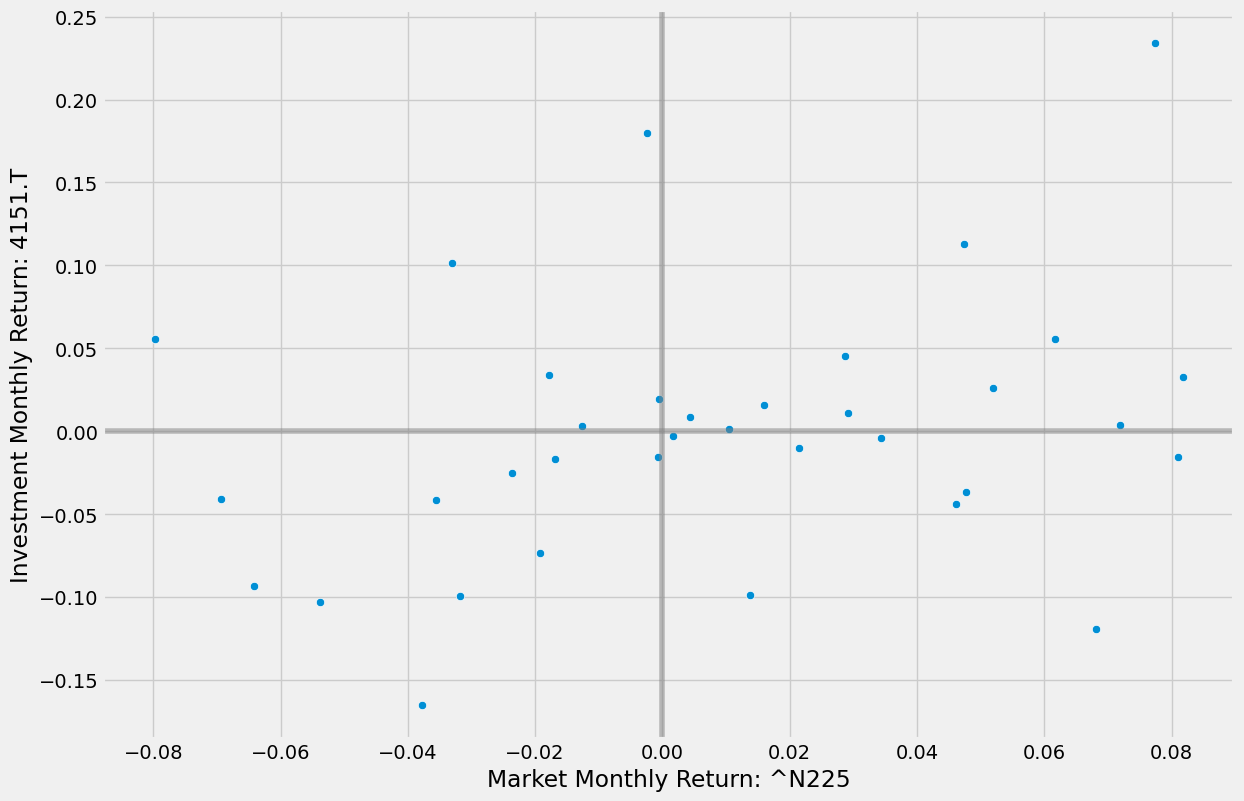

In [10]:
plt.figure(figsize = (13,9))

plt.axvline(0, color='grey', alpha = 0.5)
plt.axhline(0, color='grey', alpha = 0.5)
sns.scatterplot(y = 'a_log_ret', x = 'm_log_ret', data = M_adjClose_merge_df)
plt.xlabel('Market Monthly Return: {}'.format(stock_m))
plt.ylabel('Investment Monthly Return: {}'.format(stock_e))
plt.show()

In [11]:
beta_reg, alpha = np.polyfit(x = M_adjClose_merge_df['m_log_ret'] , 
                             y = M_adjClose_merge_df['a_log_ret'] ,deg = 1)
print('Beta from Linear Regression: ',beta_reg.round(4))
print('Alpha: ', alpha.round(3))

Beta from Linear Regression:  0.55
Alpha:  -0.006


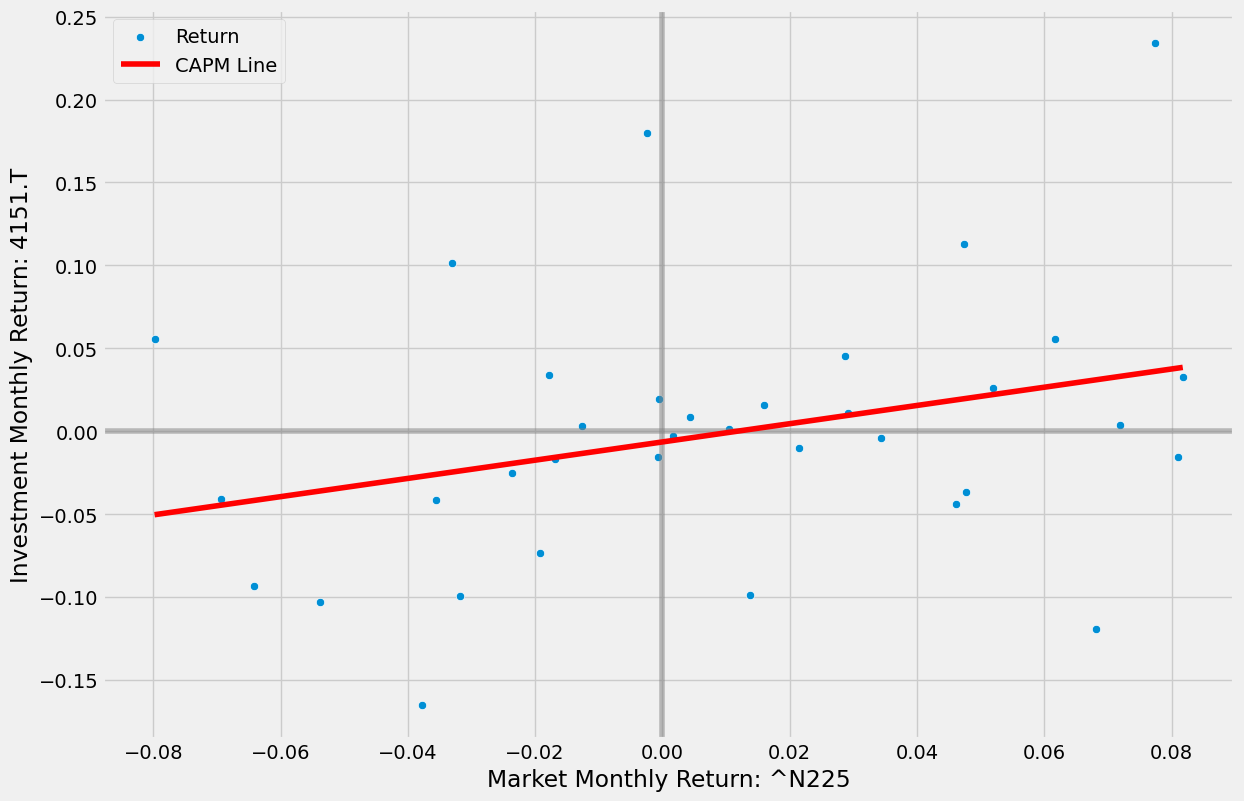

In [12]:
plt.figure(figsize = (13,9))

plt.axvline(0, color='grey', alpha = 0.5)
plt.axhline(0, color='grey', alpha = 0.5)
sns.scatterplot(y = 'a_log_ret', x = 'm_log_ret', data = M_adjClose_merge_df, label="Return")
sns.lineplot(x = M_adjClose_merge_df['m_log_ret'], 
             y = alpha + M_adjClose_merge_df['m_log_ret']*beta_reg, 
             color = 'red', label = 'CAPM Line')

plt.xlabel('Market Monthly Return: {}'.format(stock_m))
plt.ylabel('Investment Monthly Return: {}'.format(stock_e))
plt.show()

### Bayesian Linear Regression

In [13]:
# prepare dataset
y = M_adjClose_merge_df["a_log_ret"].values
X = M_adjClose_merge_df["m_log_ret"].values

In [14]:
# Define a probabilistic model
model = pm.Model()

with model:
    y_data = pm.Data("y_data", y, mutable=True)
    X_data = pm.Data("X_data", X, mutable=True)

    beta = pm.Normal("beta", mu=0, sigma=10)
    alpha = pm.Normal("alpha", mu=0, sigma=10)

    mu = pm.Deterministic("mu", beta * X_data + alpha)

    epsilon = pm.HalfNormal("epsilon", sigma=10)

    y_pred = pm.Normal("y_pred", mu=mu, sigma=epsilon, observed=y_data)    

# g = pm.model_to_graphviz(model)
# display(g)

In [15]:
# MCMC sampling
with model:
    idata = pm.sample(
        chains = 2,
        tune = 1000,
        draws = 2000,
        random_seed = 42
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [beta, alpha, epsilon]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 1 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


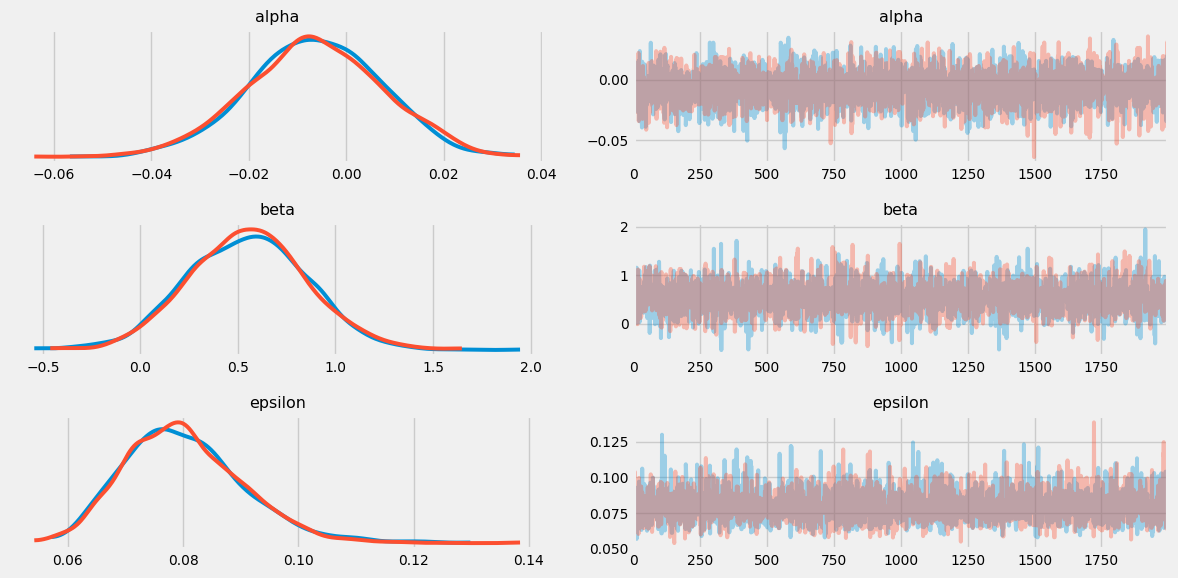

In [16]:
# Visualize the posterior distribution
az.plot_trace(idata, compact=False, var_names=["alpha", "beta", "epsilon"])
plt.tight_layout();

In [17]:
# Statistics of MCMC samples
az.summary(idata, var_names=["alpha", "beta", "epsilon"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-0.006,0.014,-0.033,0.019,0.000,0.000,4930.0,2954.0,1.0
beta,0.547,0.309,-0.017,1.120,0.005,0.004,4456.0,2998.0,1.0
epsilon,0.080,0.010,0.063,0.100,0.000,0.000,3296.0,2376.0,1.0


In [18]:
# get beta and sort
beta_array = idata.posterior.beta.values.flatten()
sort_beta_li = np.sort(beta_array)
sort_beta_li = sort_beta_li[sort_beta_li > 0]

# count index 
n_index = len(sort_beta_li)

# extract bunber
n_select = 100

# create index
indices = np.linspace(0, n_index-1, n_select, dtype=int)

# get extracted parameter
sampling_beta = [sort_beta_li[i] for i in indices]

In [19]:
sampling_beta

[0.0009652040234735189,
 0.03869447639839446,
 0.05966102362936118,
 0.08097204772436999,
 0.1015667537883305,
 0.12059758854483657,
 0.14190536313907096,
 0.16191931134401066,
 0.17947280846175703,
 0.19355619036917956,
 0.20727743059662834,
 0.22067074367239334,
 0.2317309765247923,
 0.24491899296785105,
 0.25561344762453797,
 0.26755944313885127,
 0.2770343556838114,
 0.28817789113882153,
 0.2965193792933833,
 0.30426667171987837,
 0.31386599586979824,
 0.32200381832353314,
 0.33372967294418054,
 0.34443883722271557,
 0.3539829338519777,
 0.36011747749737655,
 0.36994940885495436,
 0.37876790682317524,
 0.3882342864167477,
 0.3993840364822777,
 0.4092319617262498,
 0.42217408077778623,
 0.43028907155135876,
 0.4381580492148543,
 0.44425794825173914,
 0.4530293350502672,
 0.4591880134726146,
 0.46509653809398405,
 0.4725948831219282,
 0.480415336811807,
 0.4891204950246851,
 0.49725224069322527,
 0.5051078446003125,
 0.5142810565510391,
 0.5210956085881622,
 0.5284692900927949,
 0.53

<Axes: >

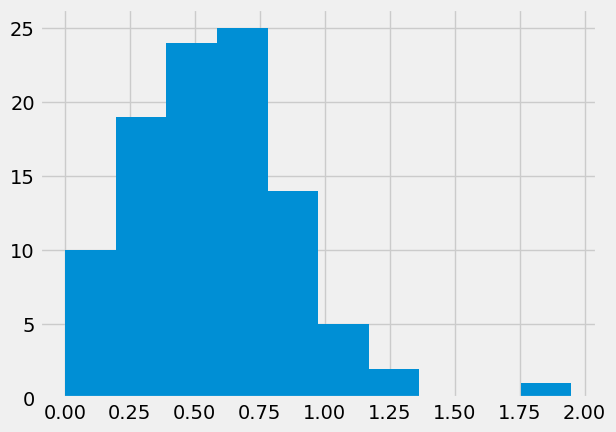

In [20]:
pd.Series(sampling_beta).hist()

## Calculate WACC

In [21]:
# free cash flow
cf_operating_act = 115551*1e6
cf_investing_act = -20382*1e6
fcf = cf_operating_act + cf_investing_act

# cost of borrowing
interest_bearing_debt = (16111+17049+8136+25718)*1e6
interest_expenses = (5767 - 245/2 + 392 + 214)*1e6
cost_of_debt = interest_expenses / interest_bearing_debt
income_tax_expense = 16058*1e6
ebt = 97246*1e6
effective_tax_rate = income_tax_expense / ebt

# cost of equity financeing(except for cost of equity)
market_capitalization = 1604880*1e6
market_portforio = 0.1140
risk_free_rate = 0.00877
market_risk_premium = market_portforio - risk_free_rate

print(effective_tax_rate)
print(cost_of_debt)

0.1651276145034243
0.09327155519742143


In [22]:
# cost of equity
cost_of_equity_li = np.array(sampling_beta) * market_portforio + risk_free_rate
print(cost_of_equity_li)

[0.00888003 0.01318117 0.01557136 0.01800081 0.02034861 0.02251813
 0.02494721 0.0272288  0.0292299  0.03083541 0.03239963 0.03392646
 0.03518733 0.03669077 0.03790993 0.03927178 0.04035192 0.04162228
 0.04257321 0.0434564  0.04455072 0.04547844 0.04681518 0.04803603
 0.04912405 0.04982339 0.05094423 0.05194954 0.05302871 0.05429978
 0.05542244 0.05689785 0.05782295 0.05872002 0.05941541 0.06041534
 0.06111743 0.06179101 0.06264582 0.06353735 0.06452974 0.06545676
 0.06635229 0.06739804 0.0681749  0.0690155  0.06996709 0.07062051
 0.07142643 0.07241349 0.07345602 0.07436237 0.07515901 0.07581968
 0.07654231 0.07738184 0.07848778 0.07978611 0.08049056 0.08114071
 0.08192137 0.08250933 0.08335845 0.083929   0.0850096  0.08577016
 0.08703525 0.08831707 0.08933248 0.09013137 0.0913183  0.09227869
 0.09301636 0.09401885 0.09476914 0.09552229 0.09654303 0.09757368
 0.09922348 0.10050662 0.1019148  0.10334498 0.10492145 0.10643904
 0.10785275 0.10907267 0.11040667 0.11215149 0.1144298  0.1160

In [23]:
# wacc
D = interest_bearing_debt
E = market_capitalization
wacc_li = []
for cost_of_equity in cost_of_equity_li:
    wacc = ( 
        D / (D+E) * (1-effective_tax_rate) * cost_of_debt
        + E / (D+E) * cost_of_equity
    )
    wacc_li.append(wacc)

wacc_li

[0.011645330159525817,
 0.015774066090148926,
 0.01806844738733874,
 0.020400524985472436,
 0.02265421549033931,
 0.024736770660450845,
 0.027068492663849752,
 0.029258630502879246,
 0.03117951976726651,
 0.03272067233252281,
 0.034222195525889135,
 0.0356878334628336,
 0.036898161091868706,
 0.038341333300466574,
 0.03951163361160729,
 0.040818890757117275,
 0.04185573587501813,
 0.04307517935566833,
 0.043987993192001376,
 0.04483578384877473,
 0.04588624340001211,
 0.04677676998181017,
 0.0480599369829769,
 0.04923184697647902,
 0.050276262948433105,
 0.05094756958045736,
 0.052023483471933155,
 0.05298849676595369,
 0.054024408118086724,
 0.05524453166713298,
 0.05632219577877656,
 0.057738459294687856,
 0.058626487392621565,
 0.05948759413472085,
 0.06015510958735122,
 0.06111496747903291,
 0.06178891519355075,
 0.06243548843405233,
 0.06325603663411941,
 0.06411183336993559,
 0.06506444382947785,
 0.06595430542518431,
 0.066813948669444,
 0.06781777851815747,
 0.06856349885877748